# Speech Emotion Recognition - HubBER Baseline Establishment and Evaluation


#### **Overview**

This stage fine-tunes a pretrained HuBERT model for Speech Emotion Recognition (SER) using the RAVDESS dataset. The objective is to classify speech into seven distinct emotional categories: neutral, happy, sad, angry, fear, disgust, and surprise.


#### **Workflow**
The implementation follows a structured pipeline consisting of the following stages:
1. **General Preparation**: Environment setup, package imports, and dataset accessibility.  
2. **Data Processing**: Dataset loading, preprocessing, and transformation into model-ready input.
3. **Model and Optimizer Initialization**: Loading the pre-trained HuBERT model and configuring the optimizer.
4. **Training**: Fine-tuning the model on the RAVDNESS labeled test dataset.
5. **Testing**: Evaluating the trained model on unseen test dataset.

## 1. General Preparation

In [1]:
# Install required packages
%%capture
!pip install datasets transformers evaluate accelerate torch
!pip install torch torchaudio

Import some common libraries

In [2]:
import time
from tqdm import tqdm
import os
import random
import pandas as pd
import numpy as np
from datasets import Dataset

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from transformers import Wav2Vec2FeatureExtractor, HubertForSequenceClassification

import soundfile as sf
import IPython.display as ipd
import librosa
import librosa.display
from IPython.display import Audio

Use GPU Facilities

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Set Seed for Reproducibility

In [21]:
SEED = 42

def set_seeds(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds(SEED)

Google drive

In [5]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Project base directory
BASE_DIR = "/content/drive/MyDrive/YourProject"

Mounted at /content/drive


## 2. Data Processing

This stage is responsible for Dataframe creation of RAVDNESS dataset and transforming raw audio samples into structured input suitable for model training and evaluation. This involves dataset loading, organization, tokenization, and conversion to a dataset object.

### 2.1 Load RAVDESS dataset

Download dataset file from website https://zenodo.org/record/1188976

In [ ]:
%%capture
![ -f Audio_Speech_Actors_01-24.zip ] && echo "File existed" || wget "https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip?download=1" -O Audio_Speech_Actors_01-24.zip

Unzip dataset file.

In [ ]:
%%capture
![ -f "./Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-01-01-01.wav" ] && echo "File existed" || unzip Audio_Speech_Actors_01-24.zip -d "./Audio_Speech_Actors_01-24/"

### 2.2 Create RAVDESS DataFrame

In [ ]:
# Process dataset
RAV = "./Audio_Speech_Actors_01-24/"
dir_list = os.listdir(RAV)
dir_list.sort()

emotion = []
gender = []
path = []
for i in dir_list:
   fname = os.listdir(RAV + i)
   for f in fname:
       part = f.split('.')[0].split('-')
       emotion.append(int(part[2]))
       temp = int(part[6])
       gender.append("female" if temp%2 == 0 else "male")
       path.append(RAV + i + '/' + f)

# Create DataFrame
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender), RAV_df, pd.DataFrame(emotion)],axis=1)
RAV_df.columns = ['gender','emotion','labels']
RAV_df['source'] = 'RAVDESS'
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df.emotion.value_counts()

,count
emotion,
sad,192
angry,192
disgust,192
calm,192
fear,192
surprise,192
happy,192
neutral,96


In [ ]:
RAV_df

,gender,emotion,labels,source,path
0,male,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_01/03-01-04-...
1,male,angry,5,RAVDESS,./Audio_Speech_Actors_01-24/Actor_01/03-01-05-...
2,male,disgust,7,RAVDESS,./Audio_Speech_Actors_01-24/Actor_01/03-01-07-...
3,male,calm,2,RAVDESS,./Audio_Speech_Actors_01-24/Actor_01/03-01-02-...
4,male,disgust,7,RAVDESS,./Audio_Speech_Actors_01-24/Actor_01/03-01-07-...
...,...,...,...,...,...
1435,female,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_24/03-01-04-...
1436,female,disgust,7,RAVDESS,./Audio_Speech_Actors_01-24/Actor_24/03-01-07-...
1437,female,calm,2,RAVDESS,./Audio_Speech_Actors_01-24/Actor_24/03-01-02-...
1438,female,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_24/03-01-04-...


In our project we examine 7 emotions:

In [ ]:
RAV_df = RAV_df[
   (RAV_df["emotion"]=="neutral") |
   (RAV_df["emotion"]=="happy") |
   (RAV_df["emotion"]=="sad") |
   (RAV_df["emotion"]=="angry") |
   (RAV_df["emotion"]=="fear") |
   (RAV_df["emotion"]=="disgust") |
   (RAV_df["emotion"]=="surprise")
]
print(f"Shape of data frame: {RAV_df.shape}")
RAV_df.emotion.value_counts()

Shape of data frame: (1248, 5)


,count
emotion,
sad,192
angry,192
disgust,192
fear,192
surprise,192
happy,192
neutral,96


### 2.3 Spliting the data
Split into training (80%) and test (20%) data.

In [ ]:
train_df, test_df = train_test_split(
    RAV_df,
    test_size=0.2,
    random_state=42,
    stratify=RAV_df['emotion']
)

Let's have a look at the training data.

In [ ]:
train_df

,gender,emotion,labels,source,path
312,female,happy,3,RAVDESS,./Audio_Speech_Actors_01-24/Actor_06/03-01-03-...
993,male,happy,3,RAVDESS,./Audio_Speech_Actors_01-24/Actor_17/03-01-03-...
945,female,angry,5,RAVDESS,./Audio_Speech_Actors_01-24/Actor_16/03-01-05-...
277,male,surprise,8,RAVDESS,./Audio_Speech_Actors_01-24/Actor_05/03-01-08-...
134,male,surprise,8,RAVDESS,./Audio_Speech_Actors_01-24/Actor_03/03-01-08-...
...,...,...,...,...,...
373,male,surprise,8,RAVDESS,./Audio_Speech_Actors_01-24/Actor_07/03-01-08-...
1072,female,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_18/03-01-04-...
1177,female,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_20/03-01-04-...
1069,female,surprise,8,RAVDESS,./Audio_Speech_Actors_01-24/Actor_18/03-01-08-...


In [ ]:
train_df["emotion"].value_counts()

,count
emotion,
angry,154
surprise,154
disgust,154
happy,153
fear,153
sad,153
neutral,77


In [ ]:
# Display the first data sample
import IPython.display as ipd
id = 0
print(train_df.iloc[id])
ipd.Audio(data=train_df.iloc[id]["path"], autoplay=True, rate=16000)

gender                                                female
emotion                                                happy
labels                                                     3
source                                               RAVDESS
path       ./Audio_Speech_Actors_01-24/Actor_06/03-01-03-...
Name: 312, dtype: object


### 2.4 Save DataFrame in Drive

In [ ]:
import os
import shutil
import pandas as pd
import pickle

def save_dataset(df, set_type, dataset_name, base_dir='datasets'):
    """Save dataset with audio files in organized structure"""
    # Create folder for this dataset type
    set_folder = os.path.join(base_dir, dataset_name, set_type)
    os.makedirs(set_folder, exist_ok=True)

    # Create audio folder
    audio_folder = os.path.join(set_folder, 'audio')
    os.makedirs(audio_folder, exist_ok=True)

    # Make a copy of the DataFrame to update paths
    new_df = df.copy()

    # Process each row
    for idx, row in df.iterrows():
        # Get audio filename
        audio_file = os.path.basename(row['path'])

        # Copy audio file
        shutil.copy2(row['path'], os.path.join(audio_folder, audio_file))

        # Update path in DataFrame
        new_df.at[idx, 'path'] = os.path.join(audio_folder, audio_file)

    # Save updated DataFrame
    new_df.to_pickle(os.path.join(set_folder, 'metadata.pkl'))
    new_df.to_csv(os.path.join(set_folder, 'metadata.csv'), index=False)

In [ ]:
train_df['aug_type'] = 'clean'
train_df['aug_params'] = None

test_df['aug_type'] = 'clean'
test_df['aug_params'] = None

In [ ]:
shared_drive_path = f"{BASE_DIR}/Datasets"
save_dataset(train_df, 'train', 'clean', base_dir=shared_drive_path)
save_dataset(test_df, 'test', 'clean', base_dir=shared_drive_path)

### 2.5 Tokenization

Prepare audio processing and encoding

In [25]:
def map_to_array(example):
   speech, _ = librosa.load(example["path"], sr=16000, mono=True)
   example["speech"] = speech
   return example

train_data = Dataset.from_pandas(train_df).map(map_to_array)
test_data = Dataset.from_pandas(test_df).map(map_to_array)

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/hubert-large-superb-er")

train_encodings = feature_extractor(list(train_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")
test_encodings = feature_extractor(list(test_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")

Map:   0%|          | 0/998 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

### 2.6 Turn data into a Dataset object

In [26]:
# Dataset class
class EmotionDataset(torch.utils.data.Dataset):
   def __init__(self, encodings, labels):
       self.encodings = encodings
       pattern = {
           1: 0,  # neutral
           2: 0,  # neutral
           3: 1,  # happy
           4: 2,  # sad
           5: 3,  # angry
           6: 4,  # fear
           7: 5,  # disgust
           8: 6   # surprise
       }
       self.labels = [pattern[x] for x in labels]

   def __getitem__(self, idx):
       item = {key: val[idx] for key, val in self.encodings.items()}
       item['labels'] = torch.tensor(self.labels[idx])
       return item

   def __len__(self):
       return len(self.labels)

train_dataset = EmotionDataset(train_encodings, list(train_data["labels"]))
test_dataset = EmotionDataset(test_encodings, list(test_data["labels"]))

In [ ]:
print(train_dataset)
print(test_dataset)

## 3. Loading the Model and Optimizer

In [ ]:
# Loading the model
model = HubertForSequenceClassification.from_pretrained(
   "superb/hubert-large-superb-er",
   num_labels=7,
   ignore_mismatched_sizes=True
)
model.to(device)

# Loading the optimizer
optim = AdamW(model.parameters(), lr=1e-5)

config.json:   0%|          | 0.00/1.83k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at superb/hubert-large-superb-er and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

HubertForSequenceClassification(
  (hubert): HubertModel(
    (feature_extractor): HubertFeatureEncoder(
      (conv_layers): ModuleList(
        (0): HubertLayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1-4): 4 x HubertLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (5-6): 2 x HubertLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): HubertFeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (pro

In [ ]:
# Right now, all the parameters are trainable
for name, param in model.named_parameters():
    print(name, param.requires_grad)

layer_weights True
hubert.masked_spec_embed True
hubert.feature_extractor.conv_layers.0.conv.weight True
hubert.feature_extractor.conv_layers.0.conv.bias True
hubert.feature_extractor.conv_layers.0.layer_norm.weight True
hubert.feature_extractor.conv_layers.0.layer_norm.bias True
hubert.feature_extractor.conv_layers.1.conv.weight True
hubert.feature_extractor.conv_layers.1.conv.bias True
hubert.feature_extractor.conv_layers.1.layer_norm.weight True
hubert.feature_extractor.conv_layers.1.layer_norm.bias True
hubert.feature_extractor.conv_layers.2.conv.weight True
hubert.feature_extractor.conv_layers.2.conv.bias True
hubert.feature_extractor.conv_layers.2.layer_norm.weight True
hubert.feature_extractor.conv_layers.2.layer_norm.bias True
hubert.feature_extractor.conv_layers.3.conv.weight True
hubert.feature_extractor.conv_layers.3.conv.bias True
hubert.feature_extractor.conv_layers.3.layer_norm.weight True
hubert.feature_extractor.conv_layers.3.layer_norm.bias True
hubert.feature_extracto

## 4. Training

Prediction function - using softmax for multiclassification task

In [13]:
# Prediction function
def predict(outputs):
   probabilities = torch.softmax(outputs["logits"], dim=1)
   predictions = torch.argmax(probabilities, dim=1)
   return predictions

Train the model

In [ ]:
# Training

from torch.utils.data import DataLoader

# Training
epoch = 7
batch_size = 8
train_loss = []
train_accuracies = []

model.train()
for epoch_i in range(epoch):
   print(f'Epoch {epoch_i + 1}/{epoch}')
   time.sleep(0.3)

   train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
   correct = 0
   count = 0
   epoch_loss = []

   pbar = tqdm(train_loader)
   for batch in pbar:
       optim.zero_grad()
       input_ids = batch['input_values'].to(device)
       attention_mask = batch['attention_mask'].to(device)
       labels = batch['labels'].to(device)
       outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
       loss = outputs['loss']
       loss.backward()
       optim.step()

       predictions = predict(outputs)
       correct += predictions.eq(labels).sum().item()
       count += len(labels)
       accuracy = correct / count

       pbar.set_postfix({
           'Loss': f'{loss.item():.3f}',
           'Accuracy': f'{accuracy:.3f}'
       })
       epoch_loss.append(loss.item())

   pbar.close()
   train_loss += epoch_loss
   train_accuracies.append(accuracy)

Epoch 1/7


100%|██████████| 125/125 [00:38<00:00,  3.28it/s, Loss=1.647, Accuracy=0.212]


Epoch 2/7


100%|██████████| 125/125 [00:38<00:00,  3.28it/s, Loss=1.539, Accuracy=0.396]


Epoch 3/7


100%|██████████| 125/125 [00:38<00:00,  3.28it/s, Loss=1.321, Accuracy=0.526]


Epoch 4/7


100%|██████████| 125/125 [00:37<00:00,  3.30it/s, Loss=0.893, Accuracy=0.652]


Epoch 5/7


100%|██████████| 125/125 [00:38<00:00,  3.27it/s, Loss=0.891, Accuracy=0.722]


Epoch 6/7


100%|██████████| 125/125 [00:38<00:00,  3.26it/s, Loss=1.399, Accuracy=0.774]


Epoch 7/7


100%|██████████| 125/125 [00:38<00:00,  3.24it/s, Loss=0.869, Accuracy=0.808]


**Visualise train process**

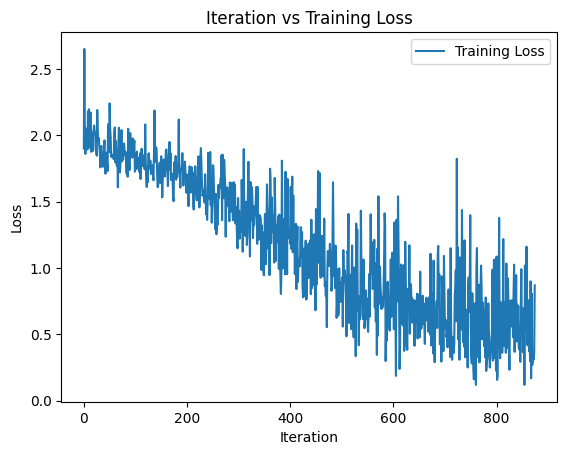

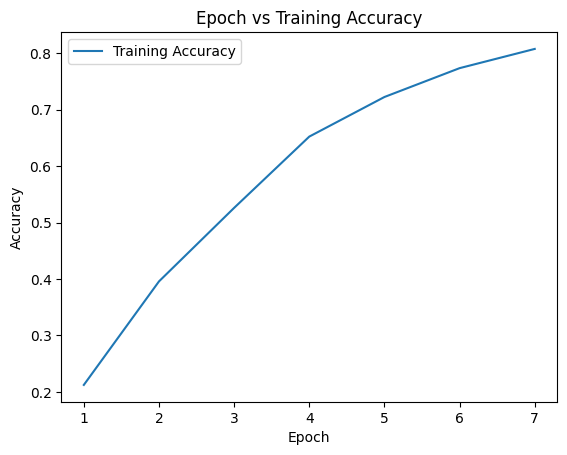

In [ ]:
# Plot Iteration vs Training Loss
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Training Loss")
plt.legend()
plt.show()

# Plot Epoch vs Training Accuracy
acc_X = np.arange(len(train_accuracies))+1
plt.plot(acc_X, train_accuracies,"-", label="Training Accuracy")
plt.xticks(acc_X)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Training Accuracy")
plt.legend()
plt.show()

**Save model**

In [ ]:
# Save model and feature extractor to Drive
save_path = f"{BASE_DIR}/Baseline"
model.save_pretrained(save_path)
feature_extractor.save_pretrained(save_path)

# Verify the save was successful
import os
saved_files = os.listdir(save_path)
print("Saved files:", saved_files)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saved files: ['model.safetensors', 'config.json', 'preprocessor_config.json']


## 5. Testing

### **Option to load model and test set**

**Load the baseline model**

In [6]:
# Load model and feature extractor from the saved path
model_path = f"{BASE_DIR}/Stage 1 - baseline creation"
model = HubertForSequenceClassification.from_pretrained(model_path)
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_path)
model.to(device)

HubertForSequenceClassification(
  (hubert): HubertModel(
    (feature_extractor): HubertFeatureEncoder(
      (conv_layers): ModuleList(
        (0): HubertLayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1-4): 4 x HubertLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (5-6): 2 x HubertLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): HubertFeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (pro

**Load the testset**

In [24]:
def load_test_sets(base_dir='test_sets_backup'):
    """
    Loads all saved test sets and restores original naming with spaces
    """
    loaded_sets = {}

    # Go through each folder in the base directory
    for set_folder in os.listdir(base_dir):
        if os.path.isdir(os.path.join(base_dir, set_folder)):
            # Load the DataFrame
            df_path = os.path.join(base_dir, set_folder, 'metadata.pkl')
            if os.path.exists(df_path):
                # Convert folder name back to original format (replace underscores with spaces)
                original_name = set_folder.replace('_', ' ')
                loaded_sets[original_name] = pd.read_pickle(df_path)

    return loaded_sets
loaded_test_sets = load_test_sets(base_dir= f"{BASE_DIR}/Datasets/RAVDNESS")
test_df = loaded_test_sets['Clean']
test_dataset = EmotionDataset(test_encodings, list(test_data["labels"]))
test_data = Dataset.from_pandas(test_df).map(map_to_array)
test_encodings = feature_extractor(list(test_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")

### **Test the model - retrieve predictions**

In [27]:
# Testing
from torch.utils.data import DataLoader

# Get test data by DataLoader
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Start testing
model.eval()

with torch.no_grad():
   correct = 0
   count = 0
   record = {"labels":[], "predictions":[]}

   pbar = tqdm(test_loader)
   for batch in pbar:
       input_ids = batch['input_values'].to(device)
       attention_mask = batch['attention_mask'].to(device)
       labels = batch['labels'].to(device)
       outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
       loss = outputs['loss']

       predictions = predict(outputs)
       correct += predictions.eq(labels).sum().item()
       count += len(labels)
       accuracy = correct / count

       pbar.set_postfix({
           'loss': f'{loss.item():.3f}',
           'accuracy': f'{accuracy:.3f}'
       })

       record["labels"] += labels.cpu().numpy().tolist()
       record["predictions"] += predictions.cpu().numpy().tolist()

   pbar.close()

print(f"Final test accuracy: {accuracy*100:.4f}%")

100%|██████████| 250/250 [00:20<00:00, 12.09it/s, loss=0.389, accuracy=0.740]

Final test accuracy: 74.0000%


### **Analysis of the results**

In [28]:
# Analysis
df_record = pd.DataFrame(record)
df_record.columns = ["Ground Truth", "Model Prediction"]

emotions = ["neutral", "happy", "sad", "angry", "fear", "disgust", "surprise"]
df_record["Ground Truth"] = df_record["Ground Truth"].apply(lambda x: emotions[x])
df_record["Model Prediction"] = df_record["Model Prediction"].apply(lambda x: emotions[x])

In [29]:
# Concat test texts and test records
df = pd.concat([test_df.reset_index(), df_record["Model Prediction"]], axis=1)
#df["emotion"] = df.apply(lambda x: x["emotion"][:3], axis=1)

# Show incorrect predictions
incorrect_predictions = df[df["emotion"] != df["Model Prediction"]]
incorrect_predictions.head(10)

,index,gender,emotion,labels,source,path,aug_type,aug_params,Model Prediction
3,1039,female,sad,4,RAVDESS,/content/drive/MyDrive/HuBERT_for_SER/Baseline...,clean,None,neutral
6,25,male,surprise,8,RAVDESS,/content/drive/MyDrive/HuBERT_for_SER/Baseline...,clean,None,happy
10,1391,female,disgust,7,RAVDESS,/content/drive/MyDrive/HuBERT_for_SER/Baseline...,clean,None,angry
16,1228,male,sad,4,RAVDESS,/content/drive/MyDrive/HuBERT_for_SER/Baseline...,clean,None,neutral
17,49,male,sad,4,RAVDESS,/content/drive/MyDrive/HuBERT_for_SER/Baseline...,clean,None,neutral
22,964,male,disgust,7,RAVDESS,/content/drive/MyDrive/HuBERT_for_SER/Baseline...,clean,None,happy
23,42,male,sad,4,RAVDESS,/content/drive/MyDrive/HuBERT_for_SER/Baseline...,clean,None,neutral
34,1408,female,happy,3,RAVDESS,/content/drive/MyDrive/HuBERT_for_SER/Baseline...,clean,None,neutral
41,960,male,disgust,7,RAVDESS,/content/drive/MyDrive/HuBERT_for_SER/Baseline...,clean,None,angry
51,677,female,disgust,7,RAVDESS,/content/drive/MyDrive/HuBERT_for_SER/Baseline...,clean,None,surprise


**Lets look at incorrect predictions**

In [18]:
samples = incorrect_predictions.sample(n=3, random_state=42)
# Loop through the selected samples and display information
for idx, row in samples.iterrows():
    print(f"Sample {idx}:")
    print(f"True Emotion: {row['emotion']}")
    print(f"Predicted Emotion: {row['Model Prediction']}")
    print("Audio:")
    ipd.display(ipd.Audio(data=row["path"], autoplay=False, rate=16000))
    print("-" * 50)

Sample 70:
True Emotion: happy
Predicted Emotion: neutral
Audio:


--------------------------------------------------
Sample 2:
True Emotion: disgust
Predicted Emotion: angry
Audio:


--------------------------------------------------
Sample 167:
True Emotion: fear
Predicted Emotion: happy
Audio:


--------------------------------------------------


**Classification report**

In [19]:
print("\nClassification Report:")
report = classification_report(
    df_record["Ground Truth"],
    df_record["Model Prediction"],
    target_names=emotions
)
print(report)


Classification Report:
              precision    recall  f1-score   support

     neutral       0.86      0.84      0.85        38
       happy       0.96      0.66      0.78        38
         sad       0.89      0.82      0.85        39
       angry       0.48      0.82      0.61        39
        fear       0.46      0.89      0.61        19
     disgust       0.89      0.41      0.56        39
    surprise       0.90      0.71      0.79        38

    accuracy                           0.72       250
   macro avg       0.78      0.74      0.72       250
weighted avg       0.80      0.72      0.73       250



**Confusion Matrix**

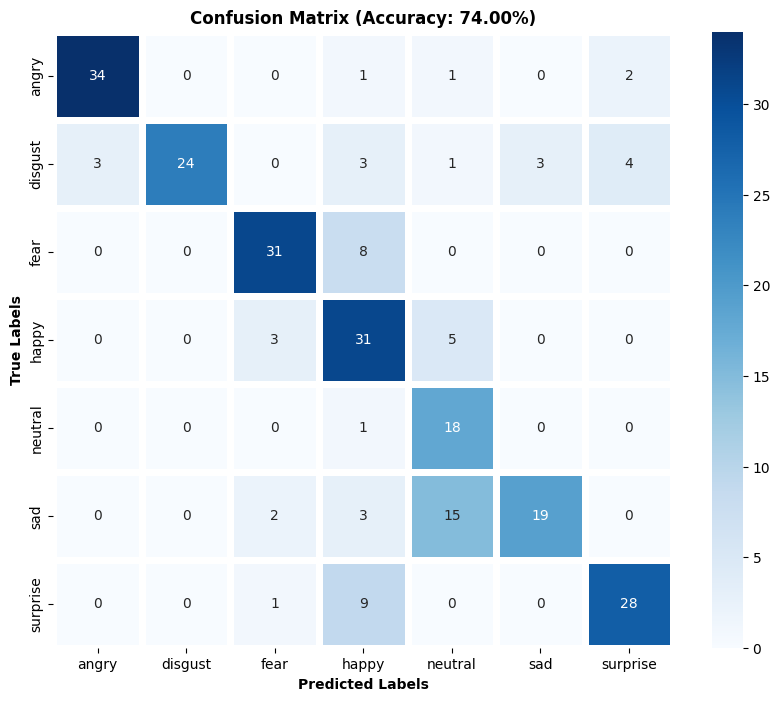

In [30]:
# Confusion Matrix
crosstab = pd.crosstab(df_record["Ground Truth"], df_record["Model Prediction"])
plt.figure(figsize=(10, 8))
sns.heatmap(crosstab, cmap='Blues', annot=True, fmt='g', linewidths=5)
accuracy = df_record["Ground Truth"].eq(df_record["Model Prediction"]).sum() / len(df_record)
plt.title(f"Confusion Matrix (Accuracy: {accuracy*100:.2f}%)", fontweight='bold')
plt.ylabel("True Labels", fontweight='bold')
plt.xlabel("Predicted Labels", fontweight='bold')
plt.show()